# Unleash The Swarm - Multi Agent Orchestration
* This notebook was forked from Adam Lucek's repository where he gave an excellent demo of the OpenAI Swarm library.
* I added some notes and details based on his tutorials from his YouTube channel.
* Date completed: 4/11/2025

# Overview
* Introducing a new proposed way of breaking down extensive agentic workflows- **Swarm**.
* Originally proposed by OpenAI in their [repo](https://github.com/openai/swarm) and [code research](https://cookbook.openai.com/examples/orchestrating_agents).
* They tackle the **limitations** of giving a single system prompt + multiple tools to an LLM for complex multi-step *routines* or processes.
  * This allows you to step outside the lines of a typical LangGraph structured workflow.

## Traditional Function Calling Agents
* This works well when you have a **Narow** or **Very Simple** workflow.
* If you had a simple chatbot that handled "refunds".
  * The 1 capability of completing the "return process" is very basic and directed result.
  * This is where the traditional function calling agents excel but their limitations arise when it gets more complicated.

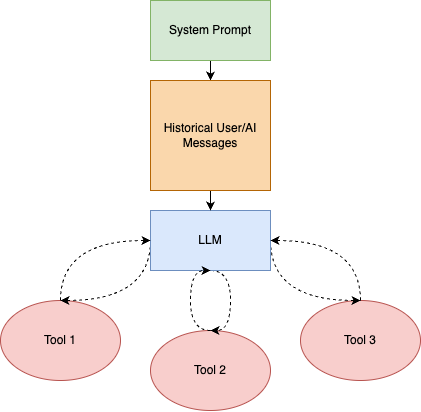


# Multi Agent Orchestration with Swarm

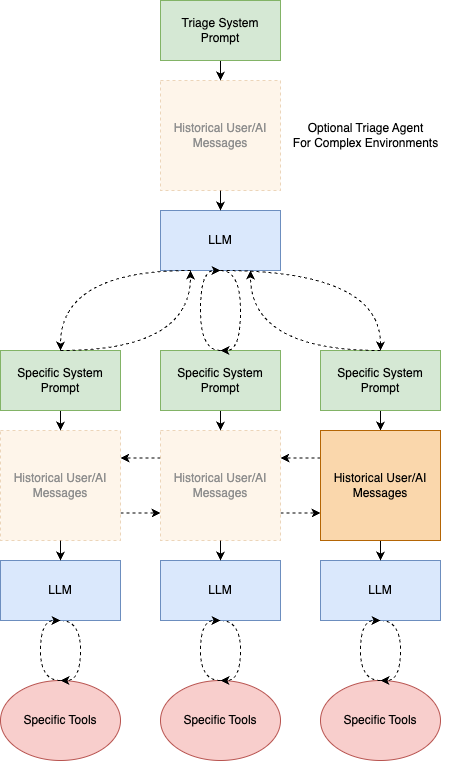


The Swarm approach looks at agentic frameworks as **dynamic, context-aware switching between specialized agents to handle complex, multi-domain conversations more effectively.** Where:

1. **Dynamic Switching**
  * The ability to change agents mid-conversation based on the **evolving needs of the interaction.**
2. **Context-Aware**
  * Maintaining and transferring conversation history between agents, **ensuring continuity and coherence.**
3. **Specialized Agents**
  * Using focused, **domain-specific agents** instead of a **single generalist agent.**
4. **Complex, Multi-Domain Conversations**
  * Addressing the challenge of handling conversations that span **multiple topics** or require different types of expertise.
5. **Improved Effectiveness**
  * Aiming to provide more appropriate and accurate responses by leveraging specialized knowledge and tools for each part of the conversation.

Summary
* Decomposing the task(s) at hand **across multiple specialized "agents" or "routines"** orchestrated through the transfer of message history with specialized system prompts and corresponding functions to better execute on overarching plans.
* As a plus, this allows **dynamic switching between specific workflows**, making it easier to specialize or tune specific routines via system prompts or tools.

---
# Routines & Handoffs

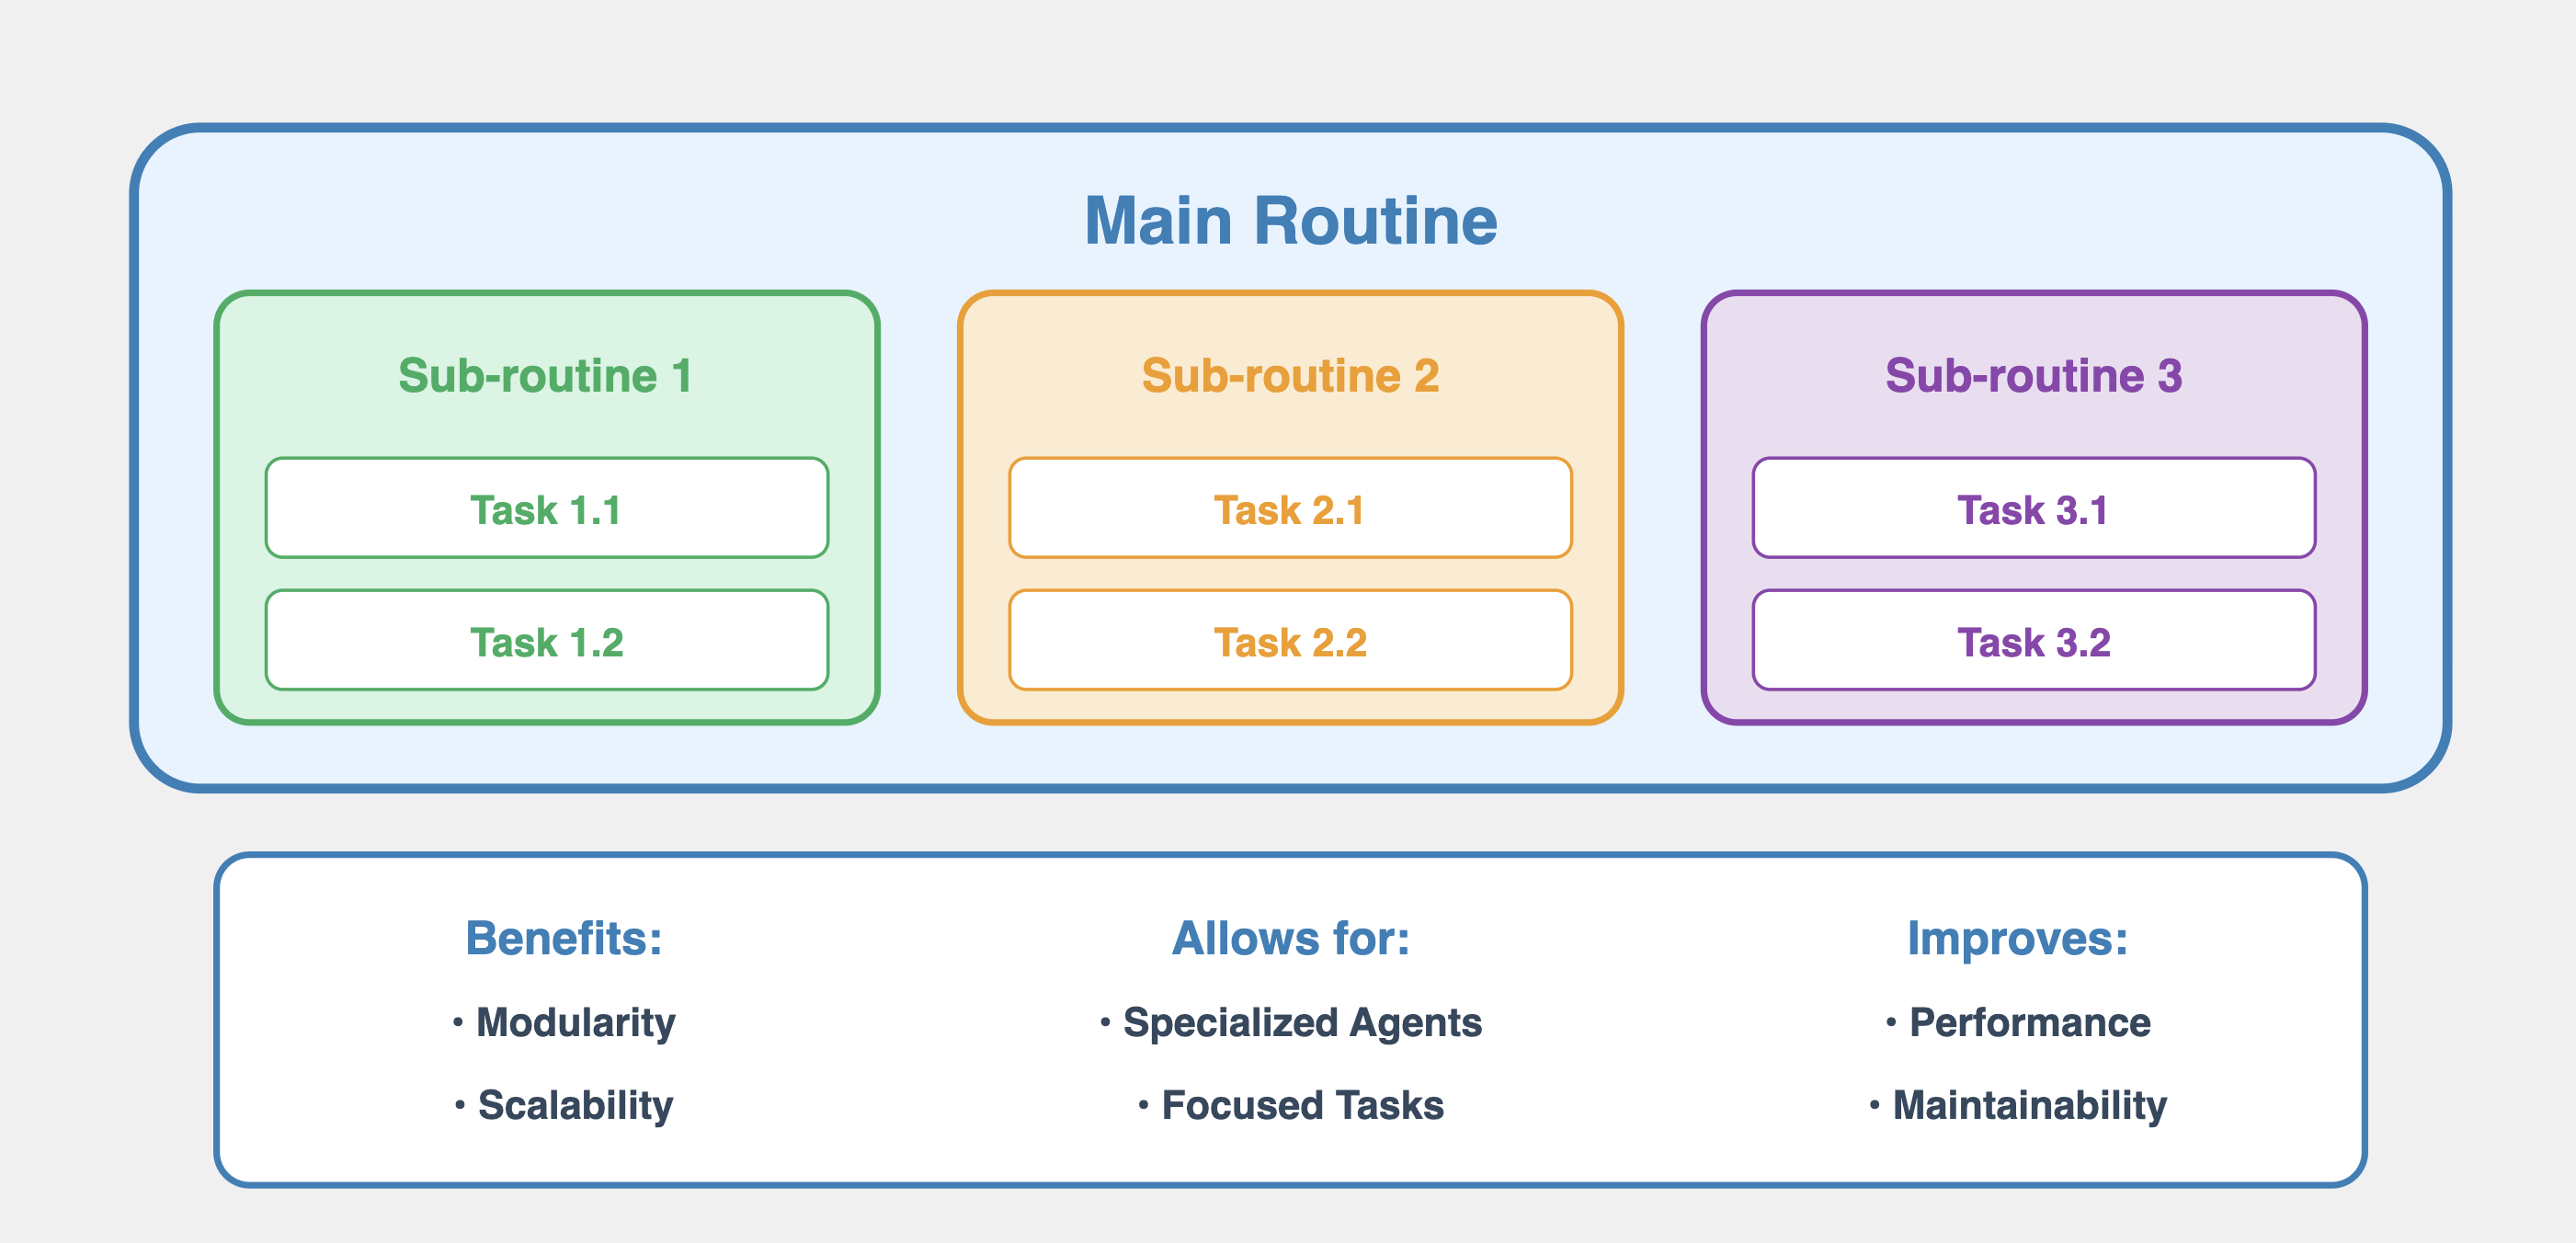

Swarm operates with two main concepts in mind: **routines** and **handoffs**

**Routines** capture the overall flow that you want your agentic structure to follow and complete. For our example, I am going to demonstrate the creation of a meal planning assistant. The routine of this might then be:

```
Understand user's meal planning needs and preferences
- Take note of dietary restrictions
- Take note of dietary preferences
Generate meal ideas based on preferences and restrictions
- Discuss the preferences
- Take note of agreed upon meals
Create recipes for the chosen meals
- Find out what the user needs help making
- Take note of all recipes needed for those meals
Compile a grocery list for all meals
- Look at the recipes and meals
- Take note of the ingredients needed for these meals
Generate a final report summarizing the meal plan, recipes, and grocery list
- Determine whether the user is satisfied
- Output a final report
```

But the main issue that we realize here is that within this routine are lots and lots of different operations that need to be executed, which can complicate things. Single prompt + tool language models tend to lose the improved performance that comes with specificity and narrow scopes as their overall routine to follow increases in length or complexity.

This is where the **handoff** comes in. Instead of having that single system prompt and relying on one language model with all the tools to accurately and effectively handle the routine, we can break down each part into a sub-routine. These routines then become their own system prompts and corresponding set of tools, or "agents". This allows us to hand off the conversation between these agents and sub-routines.

```
Routine 1: Triage and Orchestration
- Direct user queries to appropriate specialized agents
- Suggest possible actions to the user
- Initiate the final report generation when appropriate

Routine 2: Meal Planning
- Gather and note dietary preferences and restrictions
- Ideate and suggest diverse meal choices
- Record agreed-upon meals (aiming for 3 different meals)

Routine 3: Recipe Creation and Grocery List Compilation
- Create detailed recipes for chosen meals
- Save recipes for future reference
- Add required ingredients to the grocery list
```

Breaking it down and adding this level of specificity allows each sub-routine to be modular and scalable. Instead of having to worry about tuning the overall flow with a large and specific system prompt, you can work on and fine-tune the individual routines that make up the overall goal.

Handing off the conversation to these different agents at different steps along the routine maintains the context and understanding, but allows our LLM to perform different specialized functions or tasks. This approach enhances the system's ability to handle complex tasks while maintaining focus and efficiency at each stage of the process.

---
# Meal Planner Assistant

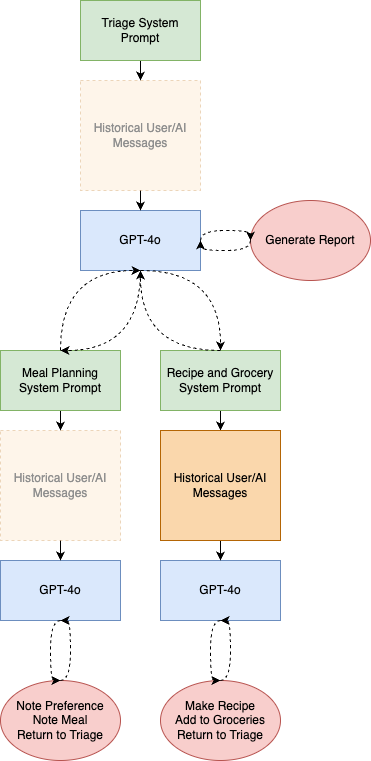

#### Install Swarm Package

In [1]:
!pip install git+https://github.com/openai/swarm.git

  Cloning https://github.com/openai/swarm.git to /tmp/pip-req-build-x7hg8sr0
  Running command git clone --filter=blob:none --quiet https://github.com/openai/swarm.git /tmp/pip-req-build-x7hg8sr0
  Resolved https://github.com/openai/swarm.git to commit 0c82d7d868bb8e2d380dfd2a319b5c3a1f4c0cb9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.7/220.7 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.6/345.6 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 26.6 MB/s eta 0:00:00
  Created wheel for swarm: filename=swarm-0.1.0-py3-none-any.whl size=25912 sha256=8565479c3f24

#### Defining The Tools

Below we have all the specific tools for each routine

1. `note_preference`: Write down user meal preferences and dietary restrictions
2. `note_meal`: Write down agreed upon meals
3. `save_recipe`: Create a recipe and write it down for
4. `add_to_grocery_list`: Add necessary groceries for recipes to grocery list
5. `generate_final_report`: Compile all information to a final report

These will all write to a text file to keep track, as well as update `context_variables` to store this in a variable.

Swarm will cover converting the python functions to tool schemas for the language model to call!

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
def note_preference(preference: str):
    """Make a note about dietary preference to keep track."""

    # Append to file
    with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/PyTorch/preferences.txt", "a") as file:
        file.write(f"{preference}\n")

    context_variables['preferences'].append(preference)

    return "Successfully noted preference!"

def note_meal(meal: str):
    """Write down a meal that has been agreed upon."""

    # Append to file
    with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/PyTorch/meals.txt", "a") as file:
        file.write(f"{meal}\n")

    context_variables['meals'].append(meal)

    return "Successfully noted meal!"

def save_recipe(recipe: str):
    """Write down a recipe for a meal."""

    # Append to file
    with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/PyTorch/recipes.txt", "a") as file:
        file.write(f"\n{recipe}\n")

    context_variables['recipes'].append(recipe)

    return "Successfully noted recipe!"

def add_to_grocery_list(items: str):
    """Add items to the grocery list"""



    # Append to file
    with open("/content/drive/MyDrive/Colab Notebooks/Deep Learning Notebooks/PyTorch/grocery_list.txt", "a") as file:
        file.write(f"{items}\n")

    context_variables['grocery_list'].append(items)

    return f"Successfully added {items} item(s) to the grocery list!"

def generate_final_report(context_variables: dict):
    """Generate a final report document from the context variables."""
    report = "Meal Planning Report\n=====================\n\n"

    # Add preferences
    report += "Dietary Preferences and Restrictions:\n"
    for pref in context_variables.get('preferences', []):
        report += f"- {pref}\n"
    report += "\n"

    # Add meals
    report += "Planned Meals:\n"
    for meal in context_variables.get('meals', []):
        report += f"- {meal}\n"
    report += "\n"

    # Add recipes
    report += "Recipes:\n"
    for recipe in context_variables.get('recipes', []):
        report += f"{recipe}\n\n"

    # Add grocery list
    report += "Grocery List:\n"
    for item in context_variables.get('grocery_list', []):
        report += f"- {item}\n"

    # Write report to file
    with open("./meal_plan/final_report.txt", "w") as file:
        file.write(report)

    return "Final report generated successfully! Saved as 'final_report.txt' in the meal_plan directory."

#### Defining our Handoffs

Handoffs are covered as function calls themselves that return the agent we want to handoff to.

We'll have one main function to go back to the triage agent that our subroutine agents can call, and then two respective functions for the triage agent to transfer to the different sub routines

In [16]:
def transfer_back_to_triage():
    """Transfer back to triage agent once task is complete, or question out of scope is asked."""
    return triage_agent

def transfer_to_recipe_agent():
    """Transfer to Recipe Agent for handling creation of recipes for the meals."""
    return recipe_agent

def transfer_to_meals_agent():
    """Transfer to Meals Agent for handling of preferences, dietary restrictions, and meals."""
    return meal_agent

#### System Prompts

* The heart of the Swarm routine approach, breaking down our main workflow into sub routines that we can specialize in
* A few Notes about the system prompts below:

1. They are more "modular" as they are separate.
2. A thought I had was why not use DSPy insteaad of these long drawn out system prompts? Imagine if you had 100's of these prompts, that would be a higher token usage/cost, but also think about how you would have to update each of those prompts! DSPy would be a great way to programmatically run these prompts in an even MORE MODULAR object oriented fashion.

In [17]:
triage_system_message = (
    "You are an expert triaging agent for a meal prepping orchestation, handling the conversation between the user and multiple specialist agents."
    "Once you are ready to transfer to the right intent, call the tool to transfer to the right agent. Do not handle requests yourself"
    "You dont need to know specifics, just the topic of the request."
    "When you need more information to triage the request to an agent, ask a direct question without explaining why you're asking it."
    "Do not share your thought process with the user! Do not make unreasonable assumptions on behalf of user."
    "Based on the conversation or when its first starting out, suggest some possible actions to take to accurately transfer the user"
    "Finally, you have the ability to compile the conversation into a report. If it looks like the user is at a good stopping point, suggest this."
    )

meal_system_message = (
    "You are a meal planning assistant."
    "Always answer in a sentence or less."
    "Always take explicit note of preferences or restrictions"
    "Follow the following routine with the user:"
    "Find all restrictions and preferences, make explicit note of them"
    "Then, help ideate different meal choices, noting down agreed upon meals"
    "Try and get to diverse 3 different meal choices"
    "Make your questions subtle and natural."
    "Once you have three meals transfer back to the triage agent."
)

recipe_system_message = (
    "You are a recipe creation assistant."
    "Keep your conversation answers brief to maintain flow"
    "Follow the following routine with the user:"
    "Determine what meals the user would like to get recipes for"
    "Then, create recipes for the meals and save them for the user"
    "Make sure to add the ingredients needed to the grocery list"
    "As well as anything else the user might need for groceries"
    "Make your responses subtle and natural."
    "At the end of the conversation, transfer back to the triage agent."
)

#### Creating the Agents

Here is where we'll finally use Swarm's `Agent` function to attach the model with the system prompts and functions.

In [18]:
from swarm import Swarm, Agent

# Agents
triage_agent = Agent(
    name="Triage Agent",
    model="gpt-4o",
    instructions=triage_system_message,
    functions=[transfer_to_meals_agent, transfer_to_recipe_agent, generate_final_report]
)

meal_agent = Agent(
    name="Meal Agent",
    model="gpt-4o",
    instructions=meal_system_message,
    functions = [note_meal, note_preference, transfer_back_to_triage]
)

recipe_agent = Agent(
    name="Recipe Agent",
    model="gpt-4o",
    instructions=recipe_system_message,
    functions = [save_recipe, add_to_grocery_list, transfer_back_to_triage]
)

#### Trying it Out!

We'll use one of Swarm's built in demo loops to test out our agentic system.

We'll also be passing in `context_variables`- Swarm's way of handling the passage of information across agents that can either be prepopulated or updated during the run.

They define it as *a dictionary of additional context variables, available to functions and Agent instructions*

In [19]:
import os
from getpass import getpass

OPENAI_API_KEY = getpass("Enter your OPENAI API KEY: ")

Enter your OPENAI API KEY: ··········


In [20]:
## set env
os.environ['OPENAI_API_KEY'] = OPENAI_API_KEY

In [ ]:
from swarm.repl import run_demo_loop

context_variables = {
    "preferences": [],
    "meals": [],
    "recipes": [],
    "grocery_list": []
}

run_demo_loop(triage_agent, stream=True, context_variables=context_variables)

Starting Swarm CLI 🐝
User: hello
Triage Agent: Hi there! How can I assist you today? Here are some options: 
- Discuss meal preferences or dietary restrictions
- Create recipes for planned meals
- Report on your current meal planning status

Please let me know what you need help with.
User: meal preferences
Triage Agent: Could you please share any specific dietary restrictions or preferences you have for your meals? This will help me connect you with the right agent.
User: milk allergy
Triage Agent: Got it! Let me transfer you to the Meals Agent to handle your meal preferences and dietary restrictions related to a milk allergy.: transfer_to_meals_agent()

Meal Agent: I'll ensure that all meal recommendations will be milk-free. Do you have any other preferences or dietary needs?
User: peanuts
Meal Agent: note_preference()
Meal Agent: note_preference()
Meal Agent: Great, I've noted your allergies to milk and peanuts. Let's explore some meal options that fit these preferences. Any specifi

In [ ]:
# Reset Texts
open('./meal_plan/preferences.txt', 'w').close()
open('./meal_plan/meals.txt', 'w').close()
open('./meal_plan/recipes.txt', 'w').close()
open('./meal_plan/grocery_list.txt', 'w').close()
open('./meal_plan/final_report.txt', 'w').close()

---
# Final thoughts

This approach optimizes the simple LLM + Tools Agent or Function Calling Agent, improving performance as scope and capabilities increase. It leverages language models' adherence to system prompts and narrowly defined "routines" with specialized tools. Dynamic swapping of prompts and tools through handoffs enables reliable execution of complex tasks.

Decomposing tasks into modular agents allows individual refinement of subroutines, reducing the need for lengthy system prompts. This modular structure facilitates easier maintenance and scalability, allowing addition of new capabilities without system-wide overhauls. The result is a more robust and adaptable AI system, capable of handling diverse scenarios efficiently while only needing the built in function calling ability.